# Collecting Typical Blobs based on pre-detected cells from multiple sections

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [86]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = min(max_0+margin,im0max)
    min_1 = max(min_1-margin,0)
    max_1 = min(max_1+margin,im1max)
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

def fun_blobs_in_polygen(blob_centroid_list, contour_vertice_coor_array, crop_min_list=[0,0]):
    contourPath = matplotlib.path.Path(contour_vertice_coor_array[:,[1,0]] - crop_min_list)
    return contourPath.contains_points(blob_centroid_list)

In [27]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
crop_0_min = 7000
crop_0_max = 13000
crop_1_min = 3000
crop_1_max = 14000
# Inside
# crop_0_min = 4000
# crop_0_max = 6000
# crop_1_min = 2400
# crop_1_max = 4400

# Whole
# crop_0_min = 0
# crop_1_min = 0
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

### Load and crop origninal images

In [17]:
# Set examine section number range and download from S3 if not available
section_begin = 152
section_end = 156
img_filename = {}
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
secList = range(section_begin, section_end +1 )

for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue           
            
    

Image file is already available. 
Image file is already available. 
Image file is already available. 
Image file is already available. 
Image file is already available. 


In [28]:
# Load image, change RGB images to grayscale image, rescale the grayscale
option_rescale_grayscale = True
option_inverse_color = False
sec = section_begin + 1

im_cropped = {}
im_rescale = {}
for tempSec in secList:
    im_cropped[tempSec] = img_as_ubyte(rgb2gray(imread(img_filename[tempSec])[crop_0_min:crop_0_max,crop_1_min:crop_1_max]))
    if option_rescale_grayscale:
        im_rescale[tempSec] = fun_rescale_grayscale_image(im_cropped[tempSec],invcol=option_inverse_color)


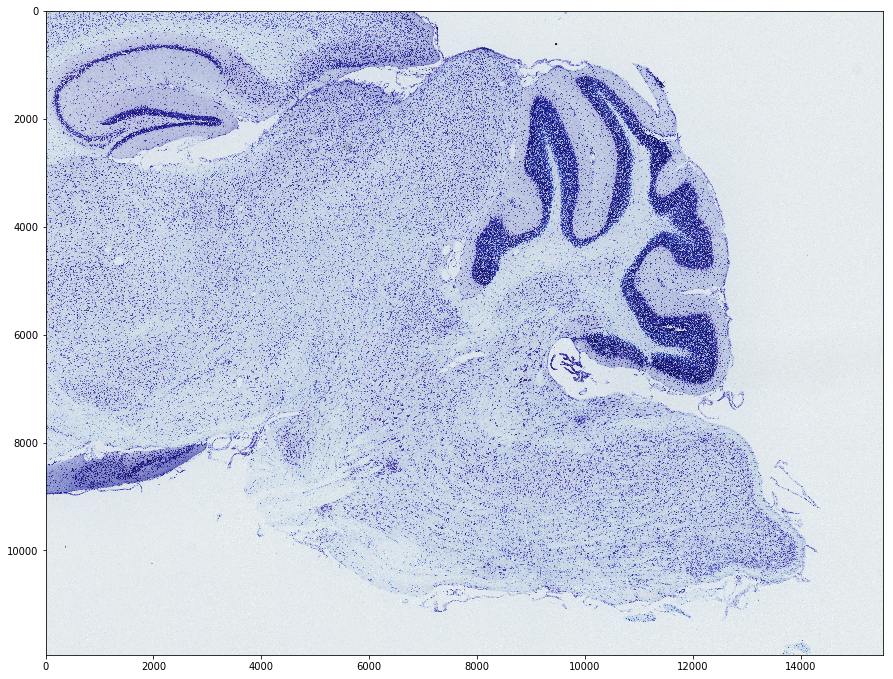

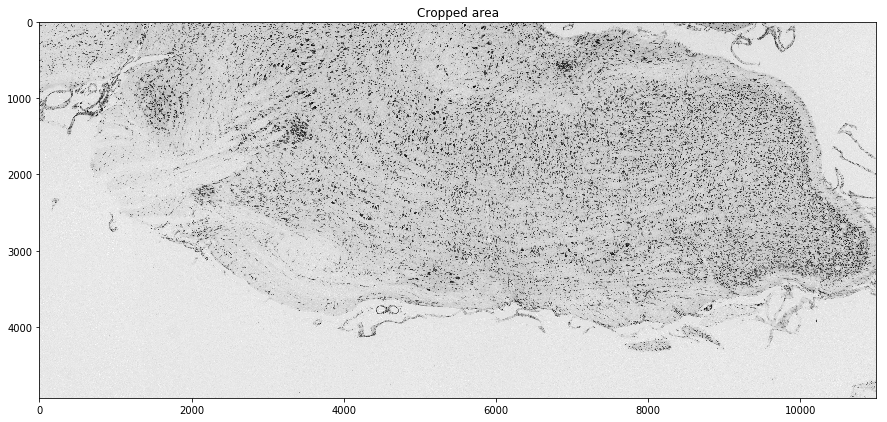

In [30]:
# Show the entire image
plt.figure(figsize=(15,15))
plt.imshow(imread(img_filename[sec]))
# Show the cropped image
plt.figure(figsize=(15,15))
plt.imshow(im_cropped[sec],cmap=plt.cm.gray)
plt.title('Cropped area')
           

### Reconstruct labeled image from detected cell dataset

In [197]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [198]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSec in secList:
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label[tempSec] = temp_im_label
    im_BW[tempSec] = temp_im_label>0
    im_blob_prop[tempSec]  = np.array(temp_im_blob_prop)

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}

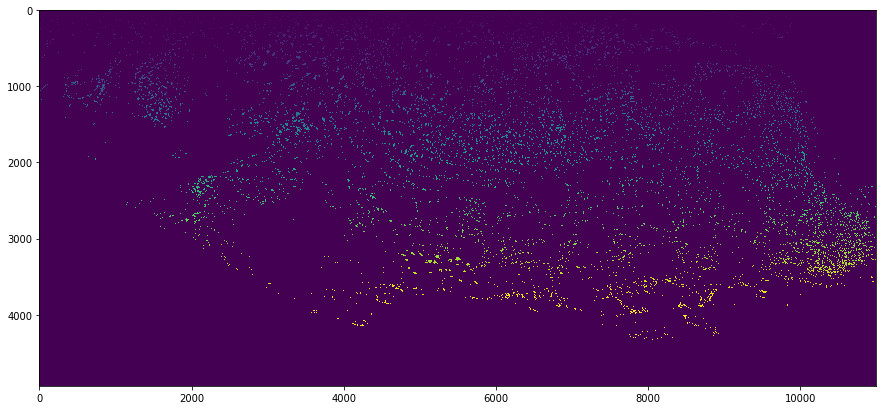

In [199]:
plt.figure(figsize=(15,15))
plt.imshow(im_label[sec])

To do list: 
1. Collect typical blobs. Typical in a sense that they match blobs in the corresponding neighboring region in the next section( based on the aligned image).
    - Read images of given sections in a given list as dictionary. Crop the brain stem area
    - Reconstruct labeled blob image
    - Write a function: input list of bolb centroid, vertice coordinate of the polygon, output the bool vector of existence
    - Check if each blob in section is typical or not. If yes, record the blob index, as well as the matched blob index in the nearby section: [sec, blobID, properties, scanSec, blobID, properties, similarity_vector]
    - Visualize the typical blob in 3D (?)
    |
    

    

In [200]:
sec = section_begin + 1
scan_section_range = 1
scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section.remove(sec)
typical_blobs = []
matched_paris = []

In [201]:
blobID = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation', 'eccentricity','equivalent_diameter','moments_hu']
o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True

temp_curr_blob_props = im_blob_prop[sec][blobID]

tempB1_idx_loc = temp_curr_blob_props['centroid']
tempB1_orientation = temp_curr_blob_props['orientation']
tempB1_hu = temp_curr_blob_props['moments_hu']
tempB1_size = temp_curr_blob_props['area']
if o_fix_scan_size:
    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
else:
    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

### Get blob properties in the next section

In [202]:
tempSec = scan_section[0]
if tempSec in secList:
    print('Section %d is in the load image list.'%tempSec)



Section 152 is in the load image list.


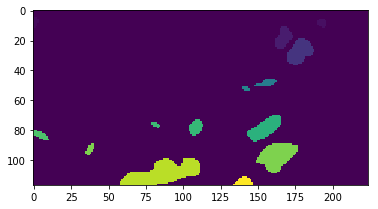

In [203]:
temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0)
temp_num_blob = len(tempBlobInsideIndex)
plt.imshow(temp_im)
if temp_num_blob:
    temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
else:
    print('No blobs found in this section')
    
    
# Get blob properties
temp_next_blob_props = {}
for tempProp in prop:
    temp_prop_value = []
    for blobIndex in range(temp_num_blob):
        temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
    temp_next_blob_props[tempProp] = temp_prop_value
temp_next_blob_props['relative_dict'] = []
for blobIndex in range(temp_num_blob):
    temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

temp_sim = {}

for temp_prop in prop_for_comparison:
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop],distance_type=temp_prop))
temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

# Blob comparsion

In [240]:
np.shape(temp_weighted_sim)

(20,)

In [204]:
# compare_weight = [6,1,3]
compare_weight = [1 for i in range(len(temp_sim_matrix[0]))]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.6

In [242]:
temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
temp_compare_result = temp_weighted_sim > o_simil_threshold
if any(temp_compare_result.tolist()):
    typical_blobs.append((sec, blobID))
    # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
    matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result] - 1],temp_sim_matrix[temp_compare_result,:]])


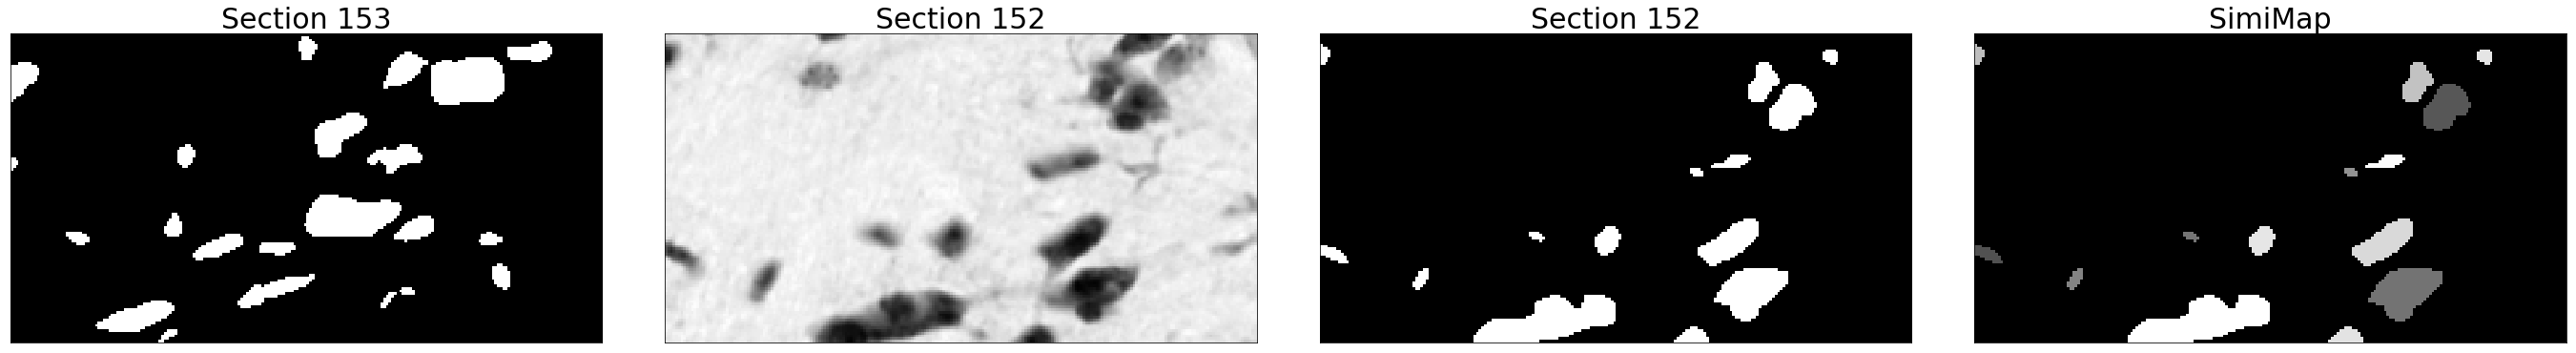

In [230]:
# Visualize the similarity score for each blob
temp_next_sec_image_sim = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D).astype(np.float)
for tempIndex in range(len(temp_weighted_sim)):
#     print(tempIndex)
#     print('Blob %d value replaced to be %f  '%(tempBlobInsideIndex[tempIndex],temp_weighted_sim[tempIndex]))
    temp_matched_pixel = (temp_next_sec_image_sim == (tempBlobInsideIndex[tempIndex]))
#     print('Number of pixel value replaced = %d \n'% np.count_nonzero(temp_matched_pixel))
    temp_next_sec_image_sim[temp_matched_pixel] = temp_weighted_sim[tempIndex]
temp_next_sec_image_sim[np.logical_or(temp_next_sec_image_sim<0,temp_next_sec_image_sim>1)] = 0
# temp_next_sec_image_sim[temp_next_sec_image_sim < o_simil_threshold] = 0
# plt.imshow(temp_next_sec_image_sim, cmap=plt.cm.gray);
# plt.colorbar();
display_images_in_grids([
                         fun_crop_images(im_BW[sec],*temp_next_sec_range_1D).astype(float) , 
    fun_crop_images(im_rescale[tempSec],*temp_next_sec_range_1D),                     
    fun_crop_images(im_BW[tempSec],*temp_next_sec_range_1D).astype(float),
                         fun_rescale_grayscale_image(temp_next_sec_image_sim)],
                        nc=4,titles=['Section %d'%sec,'Section %d'%tempSec,  'Section %d'%tempSec,'SimiMap'], cmap=plt.cm.gray)

# Integrated - blob comparsion

In [294]:
# Parameters
sec = section_begin + 1
scan_section_range = 1
scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
scan_section.remove(sec)
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation','moments_hu']
typical_blobs = []
matched_paris = []
compare_weight = [1 for i in range(len(prop_for_comparison) + 6)]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.8

o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True


In [296]:
for blobID in range(n_blobs[sec]):
    if (blobID % 1000) == 0:
        print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
    temp_curr_blob_props = im_blob_prop[sec][blobID]
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

    #################################
    for tempSec in scan_section:
        if tempSec not in secList:
#             print('Section %d is not in the load image list.'%tempSec);
            continue
        # Find blobs in the scaned section
        temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
        tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue
            
            
        # Get blob properties
        temp_next_blob_props = {}
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_num_blob):
                temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_num_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}

        for temp_prop in prop_for_comparison:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

        # Blob comparison


        temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
        temp_compare_result = temp_weighted_sim > o_simil_threshold
        if any(temp_compare_result.tolist()):
            typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
            # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
            matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])


Finished percentage: 0.000000
Finished percentage: 6.674676
Finished percentage: 13.349353
Finished percentage: 20.024029
Finished percentage: 26.698705
Finished percentage: 33.373381
Finished percentage: 40.048058
Finished percentage: 46.722734
Finished percentage: 53.397410
Finished percentage: 60.072087
Finished percentage: 66.746763
Finished percentage: 73.421439
Finished percentage: 80.096115
Finished percentage: 86.770792
Finished percentage: 93.445468


In [301]:
typical_blob_idx = [(temp[0],temp[1], temp[2]) for temp in typical_blobs]

In [303]:
len(set(typical_blob_idx))

1765

In [299]:
print('Times of finding matched blobs = %d' %len(typical_blob_idx))
print('Number of matched blobs = %d'% len(set(typical_blob_idx)))
print('Number of blobs that find matches in multiple layers = %d'% (len(typical_blob_idx) - len(set(typical_blob_idx))) )

Times of finding matched blobs = 3992
Number of matched blobs = 1765
Number of blobs that find matches in multiple layers = 2227
